In [1]:
library(dplyr)
library(caTools)
library(mltools)
library(MASS)
library(leaps)
library(glmnet)
library(ISLR)
library(tidyverse)
library(car)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: Matrix

Loaded glmnet 3.0-2


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0.9000     ✔ purrr   0.3.4     
✔ tibble  3.0.0          ✔ stringr 1.4.0     
✔ tidyr   1.0.2          ✔ forcats 0.5.0     
✔ readr   1.3.1          

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::expand()     masks Matrix::expand()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()
✖ tidyr::pack()       masks Matrix::pack()
✖ tidyr::replace_na() masks mltools::replace_na()
✖ MASS::select()      masks dplyr::select()
✖ tidyr::unpack()     masks Matrix::unpack()

Loadin

In [2]:
train = read.csv('/kaggle/input/electricity-consumption/train.csv')
test = read.csv('/kaggle/input/electricity-consumption/test.csv')

In [3]:
head(train, 5)

,ID,datetime,temperature,var1,pressure,windspeed,var2,electricity_consumption
,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
1,0,2013-07-01 00:00:00,-11.4,-17.1,1003,571.910,A,216
2,1,2013-07-01 01:00:00,-12.1,-19.3,996,575.040,A,210
3,2,2013-07-01 02:00:00,-12.9,-20.0,1000,578.435,A,225
4,3,2013-07-01 03:00:00,-11.4,-17.1,995,582.580,A,216
5,4,2013-07-01 04:00:00,-11.4,-19.3,1005,586.600,A,222


In [4]:
electricity_consumption = 0
test = cbind(test, electricity_consumption)

data = rbind(train, test)

In [5]:
colSums(is.na(data))
data = separate(data, "datetime", c("Date", "Time"), sep = " ")
data = separate(data, "Date", c("Year", "Month", "Day"), sep = "-")
data = separate(data, "Time", c("Hour"), sep = ":")

ID                datetime             temperature 
                      0                       0                       0 
                   var1                pressure               windspeed 
                      0                       0                       0 
                   var2 electricity_consumption 
                      0                       0

Warning message:
“Expected 1 pieces. Additional pieces discarded in 35064 rows [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”


In [6]:
data$Year = as.factor(data$Year)
data$Month = as.factor(data$Month)
data$Day = as.factor(data$Day)
data$Hour = as.factor(data$Hour)
data$var2 = as.factor(data$var2)

In [7]:
train_ = data[1:nrow(train),-c(1)]
test_ = data[(nrow(train) + 1):nrow(data),-c(1)]

In [8]:
set.seed(123)
split = sample.split(train_$electricity_consumption, SplitRatio = 0.8)
training_set = subset(train_, split==TRUE)
testing_set = subset(train_, split==FALSE)

In [9]:
X = model.matrix(electricity_consumption ~ ., data = training_set)[,-1]
X_test = model.matrix(electricity_consumption ~ ., data = testing_set)[,-1]

# Linear Regression

In [10]:
lm.fit = lm(electricity_consumption ~ ., data = training_set)
summary(lm.fit)


Call:
lm(formula = electricity_consumption ~ ., data = training_set)

Residuals:
    Min      1Q  Median      3Q     Max 
-225.84  -54.44  -12.95   37.67 1086.45 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 809.4203    78.2230  10.348  < 2e-16 ***
Year2014     -8.6811     2.1919  -3.961 7.50e-05 ***
Year2015     -4.2866     2.1957  -1.952 0.050926 .  
Year2016      3.3281     2.1947   1.516 0.129431    
Year2017     -4.4775     2.7479  -1.629 0.103235    
Month02      -2.6124     2.9136  -0.897 0.369924    
Month03      44.2101     3.1725  13.935  < 2e-16 ***
Month04     154.8873     3.8304  40.437  < 2e-16 ***
Month05     228.0080     4.8585  46.929  < 2e-16 ***
Month06     309.4309     6.2132  49.802  < 2e-16 ***
Month07     346.5347     6.5699  52.746  < 2e-16 ***
Month08     329.8895     6.2338  52.920  < 2e-16 ***
Month09     274.9472     5.1186  53.715  < 2e-16 ***
Month10     190.3003     4.0263  47.264  < 2e-16 ***
Month11     116.2135     3

In [11]:
pred_lm = predict(lm.fit, newx = X_test)
sqrt(mean((testing_set$electricity_consumption - pred_lm)^2))

Warning message in testing_set$electricity_consumption - pred_lm:
“longer object length is not a multiple of shorter object length”


[1] 123.3809

# Subsetting

In [12]:
nvmax_ = 9

subset.fit = regsubsets(electricity_consumption ~ ., data = training_set, method='backward', nvmax = nvmax_)
k = summary(subset.fit)
print('R-Squared')
k$adjr2

val.errors = rep(NA, nvmax_)
for(i in 1:nvmax_){
  coefi = coef(subset.fit, id=i)
  pred = cbind(1, X_test[,names(coefi[-c(1)])]) %*% coefi
  val.errors[i]= sqrt(mean((testing_set$electricity_consumption - pred) ^2))
}
print('RMSEs')
val.errors
print('Best RMSE')
val.errors[which.min(val.errors)]

Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“8  linear dependencies found”


Reordering variables and trying again:
[1] "R-Squared"


[1] 0.01778821 0.03909651 0.06894335 0.09282302 0.13028463 0.17255339
 [7] 0.21508198 0.27760258 0.32095814 0.33336323

[1] "RMSEs"


[1] 104.3724 103.6481 103.3940 103.3353 103.2134 103.2557 103.2603 102.9200
[9] 102.9200

[1] "Best RMSE"


[1] 102.92

# Lasso

Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”


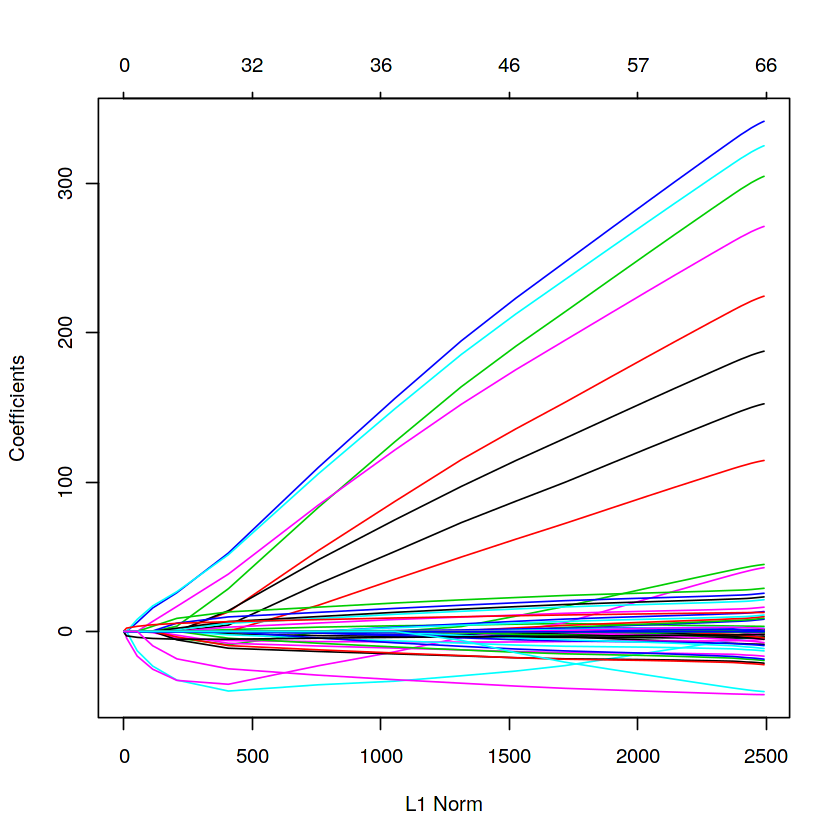

In [13]:
ld = 10^seq(10, -2, length=100)

y = training_set$electricity_consumption
rig.fit = glmnet(X, y, alpha=1, lambda=ld)
plot(rig.fit)

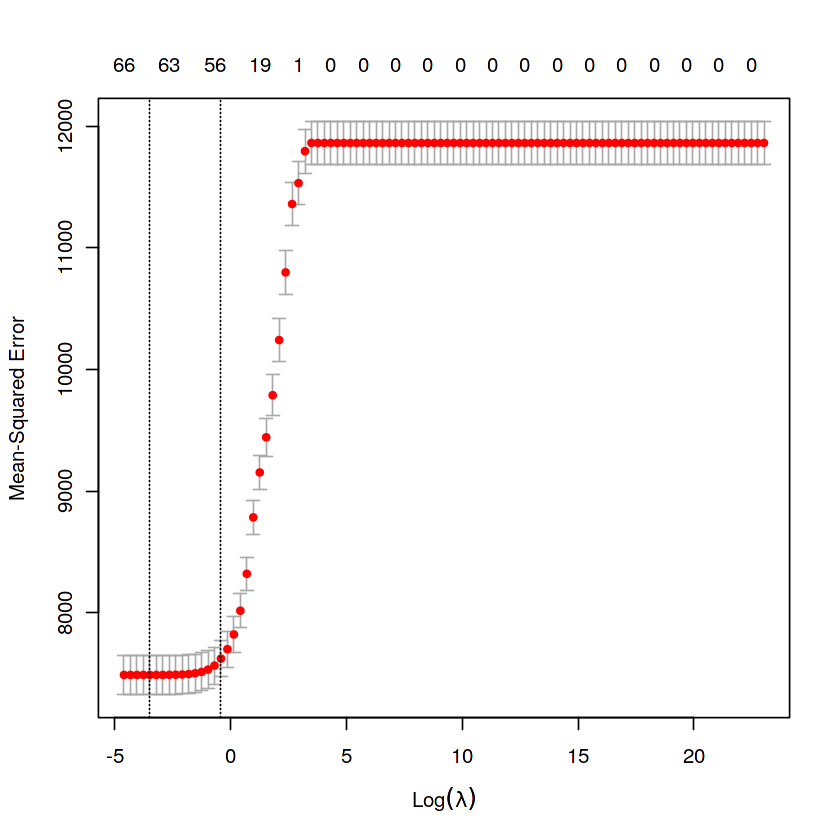

In [14]:
cvglm = cv.glmnet(X, y, alpha=1, lambda=ld, nfolds=5)
plot(cvglm)

In [15]:
best = cvglm$lambda.min
best

[1] 0.03053856

In [16]:
predict(rig.fit, s=best, type='coefficients')

75 x 1 sparse Matrix of class "dgCMatrix"
                      1
(Intercept) 799.9840708
Year2014     -8.4844760
Year2015     -4.2030644
Year2016      3.4490940
Year2017     -4.4040501
Month02      -3.9469024
Month03      41.5636970
Month04     150.8211023
Month05     222.3170437
Month06     301.9619936
Month07     338.6933355
Month08     322.4648355
Month09     268.9073497
Month10     185.9254162
Month11     113.2426753
Month12      44.0209519
Day02        -2.1794924
Day03         1.5886352
Day04        -2.3437971
Day05        -3.7840547
Day06        -1.8650301
Day07        -4.0635626
Day08         7.5270464
Day09         0.5071795
Day10        -5.7598551
Day11        -4.0108859
Day12         0.5257741
Day13         8.2311773
Day14        12.7231298
Day15        20.6386387
Day16         .        
Day17         0.7620867
Day18         9.3126788
Day19        28.2994775
Day20        24.9788332
Day21        10.4071327
Day22        15.6632085
Day23        22.5247619
Day24         .       

In [17]:
pred_rl = predict(rig.fit, s=best, newx = X_test)
sqrt(mean((testing_set$electricity_consumption - pred_rl)^2))

[1] 82.39658

In [18]:
# Predicting the test set
test_set = model.matrix(electricity_consumption ~ ., data = test_)[,-1]
pred_test = predict(rig.fit, s=best, newx = test_set)

In [19]:
submission = data.frame('ID'=test$ID, pred_test)
names(submission)[2] = 'electricity_consumption'

write.csv(submission, 'Lasso.csv', row.names = F)